In [29]:
# data pre-processing, refer Vittorio's and Sharan's code
# pre-process Airspeck data, combine with coughing data in 1 minute frequency

In [24]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os 
from os import listdir
from os.path import isfile, join
import pathlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

In [25]:
# meta
# hard-coded thresholds for features
ap_thresholds = pd.read_csv("preprocessing_meta/AP_thresholds.csv", index_col=0)
mc_thresholds = pd.read_csv("preprocessing_meta/MC_thresholds.csv", index_col=0)

In [26]:
def standardise_a(a, feature):
    '''
    standardization with mean and std from LOWESS
    '''
    try:
        lowess = sm.nonparametric.lowess
        # Estimate the trend
        a[f"mean_{feature}"] = lowess(a[feature], a.index, frac=30 / a.shape[0])[:, 1] # estimate with window of 30 min
        # Estimate the standard deviation
        a[f"sd_{feature}"] = a[feature].rolling(30).std().interpolate(method="linear")
        a[f"sd_{feature}"] = a[f"sd_{feature}"].apply(lambda x: a[f"sd_{feature}"].iloc[29] if math.isnan(x) else x)
        # Subtract the mean and divide by the standard deviation
        a[feature] = (a[feature] - a[f"mean_{feature}"]) / a[f"sd_{feature}"] # normalization
    except:
        print(f'Error when process feature: {feature}')

    return a.drop(columns=[f"mean_{feature}", f"sd_{feature}"])

In [27]:
# visualize data before pre-processing

In [28]:
def get_origin_airspeck(id):
    '''
    Preprocess and return a dataframe of airspeck measurements for a given ID.
    '''

    cohort = id[1:3]
    file = f"../data/DAPHNE/airspeck_{cohort}/{id}_airspeck_personal_manual.csv"
    airspeck = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    # drop duplicate timestamps
    airspeck = airspeck.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    # add missing observations, resample with frequency of 1s
    airspeck = airspeck.resample("1T").mean()

    # features I care about
    features = ["pm2_5", "temperature", "humidity", 'gpsLongitude', 'gpsLatitude', 'gpsAccuracy', 'bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8',
       'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15']
    
    return airspeck[features]

In [30]:
air_demo = get_origin_airspeck('DAP120(1)')

In [34]:
air_demo = air_demo[:2000]

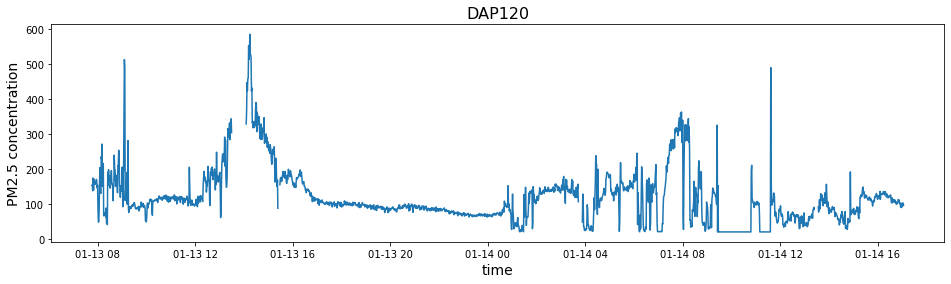

In [35]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(air_demo.index.values, air_demo["pm2_5"])
plt.ylabel('PM2.5 concentration', fontsize=14)
plt.xlabel('time',fontsize=14)
plt.title('DAP120',fontsize = 16)
plt.savefig("results/raw/spike_remove.pdf")

In [6]:
def get_airspeck(id):
    '''
    Preprocess and return a dataframe of airspeck measurements for a given ID.
    '''

    cohort = id[1:3]
    file = f"../data/DAPHNE/airspeck_{cohort}/{id}_airspeck_personal_manual.csv"
    airspeck = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    # drop duplicate timestamps
    airspeck = airspeck.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    # add missing observations, resample with frequency of 1s
    airspeck = airspeck.resample("1T").mean()

    # features I care about
    features = ["pm2_5", "temperature", "humidity", 'gpsLongitude', 'gpsLatitude', 'gpsAccuracy', 'bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8',
       'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15']
    # percentiles used in smoothing - these are percentiles
    # of the distribution of the local standard deviation of 
    # each feature, used to identify any incorrect spikes in the data
    percentiles = ["99", "99", "90"]
    for feature, percentile in zip(features[:3], percentiles):
        # hard thresholds
        if cohort == "AP":
            lower, upper = ap_thresholds.loc[feature].values
        else:
            lower, upper = mc_thresholds.loc[feature].values
        airspeck[feature] = airspeck[feature].apply(lambda x: x if x > lower and x < upper else np.nan)  
        # also deal with infinite values
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == np.inf else x)
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == -np.inf else x)

        # smooth features by directly removing spikes    
        smoothing_thresholds = pd.read_csv(f"preprocessing_meta/smoothing_{cohort}/{feature}_std_quantiles.csv", index_col=0)
        cutoff = smoothing_thresholds.loc[5, percentile]
        airspeck["spikes"] = (airspeck.loc[:, feature].diff().abs() < cutoff).values
        # df.diff().abs(): absolute difference from the value of previous row
        airspeck[feature] = airspeck.apply(lambda row: row[feature] if row.spikes else np.nan, axis=1)
    
    for feature in features[3:]:
        # deal with infinite values
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == np.inf else x)
        airspeck[feature] = airspeck[feature].apply(lambda x: np.nan if x == -np.inf else x)
    
    return airspeck[features]

In [7]:
df_a = get_airspeck('DMC052(1)')
df_a

,pm2_5,temperature,humidity,gpsLongitude,gpsLatitude,gpsAccuracy,bin0,bin1,bin2,bin3,...,bin6,bin7,bin8,bin9,bin10,bin11,bin12,bin13,bin14,bin15
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-03 11:40:00,NaN,NaN,NaN,77.272625,28.707163,7.026500,402.000000,148.750000,79.000000,62.000000,...,50.500000,20.750000,9.750000,5.000000,2.000000,1.250000,1.000000,0.000000,0.000000,0.000000
2019-04-03 11:41:00,43.613077,34.3,37.800000,77.272601,28.707164,8.738500,396.500000,140.333333,89.500000,66.666667,...,51.666667,19.000000,7.333333,3.666667,1.666667,0.666667,0.000000,0.166667,0.000000,0.166667
2019-04-03 11:42:00,42.587719,34.3,38.571429,77.272604,28.707166,8.492714,394.714286,136.857143,74.857143,57.571429,...,45.857143,19.571429,6.000000,4.714286,1.571429,0.857143,0.285714,0.142857,0.142857,0.285714
2019-04-03 11:43:00,42.038648,34.3,38.800000,77.272604,28.707168,7.870500,433.833333,129.666667,78.000000,58.000000,...,46.666667,18.500000,7.500000,3.833333,2.333333,0.666667,0.333333,0.000000,0.000000,0.000000
2019-04-03 11:44:00,46.495418,34.3,38.900000,77.272604,28.707167,8.048000,457.833333,150.666667,98.000000,78.166667,...,63.833333,23.166667,9.333333,7.666667,2.333333,1.333333,1.333333,0.166667,0.000000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-04 11:56:00,43.392528,38.8,34.814286,77.272573,28.707157,7.661857,382.285714,204.142857,122.142857,51.857143,...,25.142857,6.714286,1.714286,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-04 11:57:00,43.477314,38.8,34.925000,77.272573,28.707156,7.460625,385.750000,222.250000,115.625000,54.375000,...,20.375000,6.750000,2.250000,0.500000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-04 11:58:00,42.765749,38.8,35.100002,77.272573,28.707156,7.512750,358.125000,197.500000,115.000000,47.875000,...,21.250000,6.000000,1.625000,0.875000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000


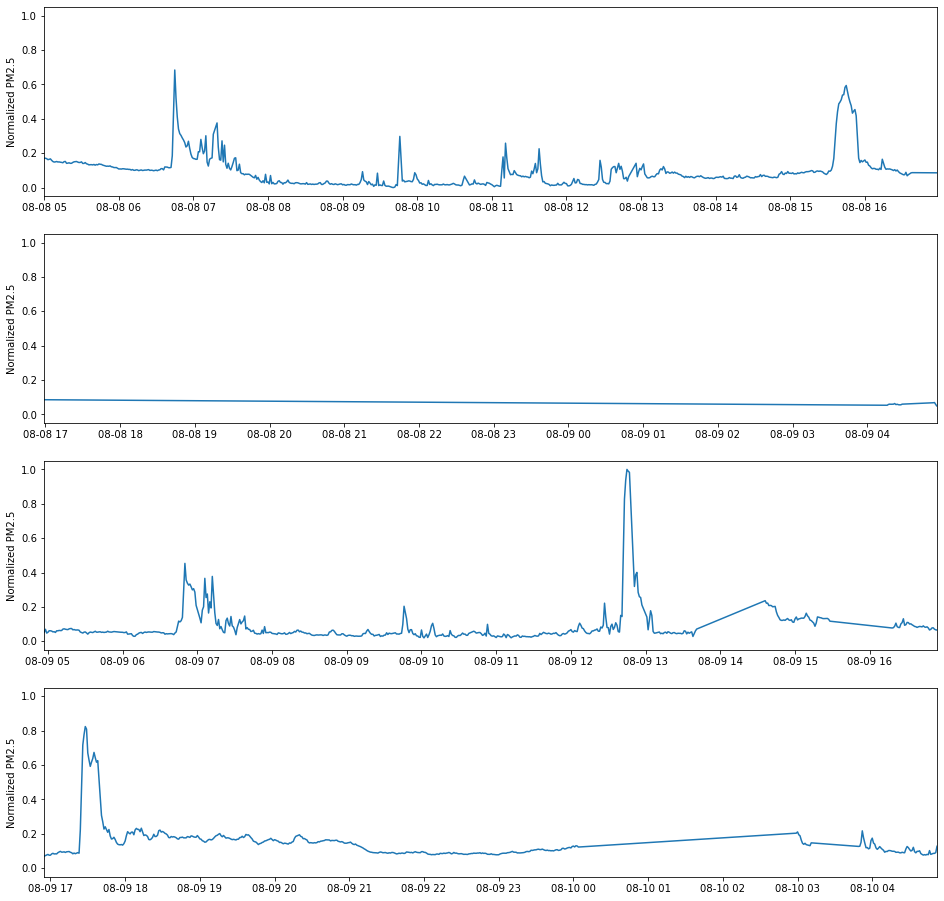

In [77]:
fig, ax = plt.subplots(4, figsize=(16, 16))
    
airspeck = get_airspeck('DAP001(1)').interpolate().ffill().bfill()
# Normalize
airspeck["pm2_5"] = MinMaxScaler().fit_transform(airspeck["pm2_5"].values.reshape(-1, 1))
# Split 48 hours in two 4 subplots of 12 hours
for i, split in enumerate(np.array_split(airspeck, 4)):
    ax[i].plot(airspeck.index.values, airspeck["pm2_5"], label=("PM2.5 concentration" if i == 0 else ""))
    ax[i].set_ylabel("Normalized PM2.5")
    ax[i].set(xlim=(split.index[0], split.index[-1]))

Text(0, 0.5, 'PM2.5')

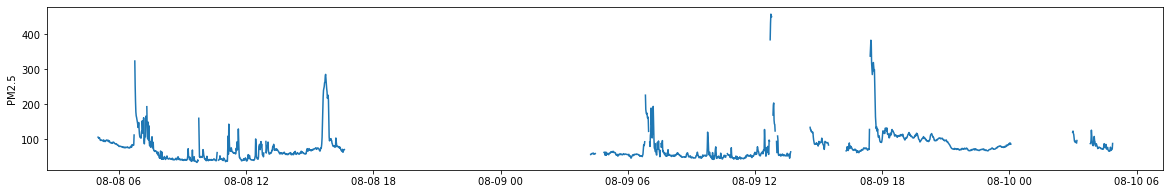

In [78]:
fig, ax = plt.subplots(figsize=(20, 3))
    
airspeck = get_airspeck('DAP001(1)')
# Normalize
#features = ['pm2_5', 'temperature', 'humidity']
#for f in features:
#    airspeck = standardise_a(airspeck, f)
# Split 48 hours in two 4 subplots of 12 hours

ax.plot(airspeck.index.values, airspeck["pm2_5"], label="PM2.5 concentration" )
ax.set_ylabel("PM2.5")
#ax.set(xlim=(split.index[0], split.index[-1]))

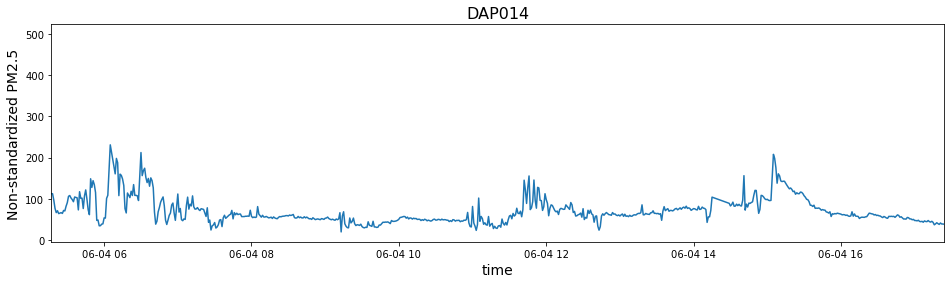

In [46]:
fig, ax = plt.subplots(figsize=(16, 4))
    
airspeck = get_airspeck('DAP014(2)').interpolate().ffill().bfill()

for i, split in enumerate(np.array_split(airspeck, 4)):
    if i<1 :
        ax.plot(airspeck.index.values, airspeck["pm2_5"])
        ax.set_ylabel("Non-standardized PM2.5")
        ax.set(xlim=(split.index[0], split.index[-1]))
        
plt.ylabel('Non-standardized PM2.5', fontsize=14)
plt.xlabel('time',fontsize=14)
plt.title('DAP014',fontsize = 16)
plt.savefig("results/raw/before_standard.pdf")

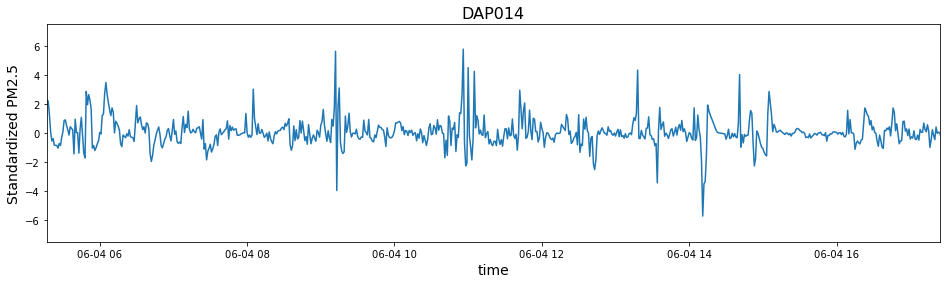

In [47]:
fig, ax = plt.subplots(figsize=(16, 4))

features = ['pm2_5', 'temperature', 'humidity']
for f in features:
    airspeck = standardise_a(airspeck, f)
# Split 48 hours in two 4 subplots of 12 hours
for i, split in enumerate(np.array_split(airspeck, 4)):
    if i<1 :
        ax.plot(airspeck.index.values, airspeck["pm2_5"])
        ax.set_ylabel("Non-standardized PM2.5")
        ax.set(xlim=(split.index[0], split.index[-1]))
        ax.set(ylim=(-7.5, 7.5))
        
plt.ylabel('Standardized PM2.5', fontsize=14)
plt.xlabel('time',fontsize=14)
plt.title('DAP014',fontsize = 16)
plt.savefig("results/raw/after_standard.pdf")

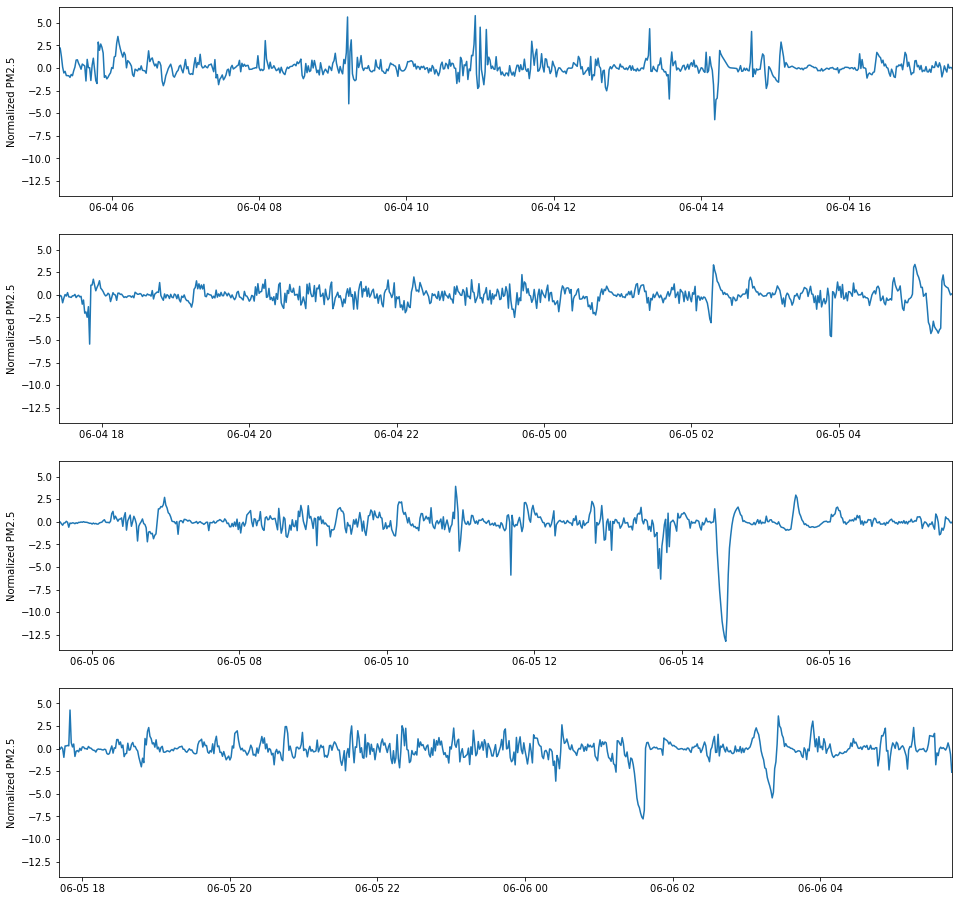

In [79]:
fig, ax = plt.subplots(4, figsize=(16, 16))
    
airspeck = get_airspeck('DAP014(2)').interpolate().ffill().bfill()
# Normalize
features = ['pm2_5', 'temperature', 'humidity']
for f in features:
    airspeck = standardise_a(airspeck, f)
# Split 48 hours in two 4 subplots of 12 hours
for i, split in enumerate(np.array_split(airspeck, 4)):
    ax[i].plot(airspeck.index.values, airspeck["pm2_5"], label=("PM2.5 concentration" if i == 0 else ""))
    ax[i].set_ylabel("Normalized PM2.5")
    ax[i].set(xlim=(split.index[0], split.index[-1]))

In [14]:
from functools import reduce
from datetime import datetime, timedelta, timezone
import operator
def prod(factors):
    return reduce(operator.mul, factors, 1)

In [17]:
def get_coughing(id):
    '''
    Return a dataframe of coughing measurements for a given ID.
    '''

    file = f"../data/DAPHNE/coughing/{id}.csv"     # use for single-level model
    #file = f"./cough_probs/{id}_cough_probs.csv"  # use for cough data from Teo
    coughing = pd.read_csv(file, infer_datetime_format=True, parse_dates=["timestamp"], index_col=["timestamp"])
    #for i in range(coughing.shape[0]):
    #    coughing.loc[i,'timestamp'] = coughing.loc[i,'timestamp'].replace(tzinfo=timezone.utc).astimezone(tz=None)
    #coughing.set_index('timestamp')
    # drop duplicate timestamps
    coughing = coughing.reset_index().drop_duplicates(subset=["timestamp"]).set_index("timestamp")
    coughing = coughing.resample('1T').agg(lambda x: 1-prod(1-x))
    
    return coughing

In [18]:
df = get_coughing('DMC032(1)')

In [19]:
df

,coughing
timestamp,
2018-12-18 07:16:00,0.999997
2018-12-18 07:17:00,0.999672
2018-12-18 07:18:00,1.000000
2018-12-18 07:19:00,1.000000
2018-12-18 07:20:00,0.999947
...,...
2018-12-19 07:40:00,0.999999
2018-12-19 07:41:00,1.000000
2018-12-19 07:42:00,0.997950


In [20]:
def get_PCMCI_data(id):
    a = get_airspeck(id).interpolate().ffill().bfill()
    # Normalize
    a = standardise_a(a, 'pm2_5')
    c = get_coughing(id)
    intersect = c.index.intersection(a.index) # find intersection of time stamp
    c = c.loc[intersect]
    data = c.merge(a, how="left", left_index=True, right_index=True)
    return data

In [21]:
subs = ['DMC032(1)', 'DMC051(1)', 'DMC052(1)']
for s in subs:
    d = get_PCMCI_data(s)
    d.to_csv(f'../data/DAPHNE/PCMCI/{s[:6]}.csv', index=True)

In [58]:
def view_missing_value(df):
    for column in list(df.columns):
        print("{}:  {} % missing values \n".format(column, ((len(df) - df[column].count()) / len(df))*100))

In [22]:
# preprocess all the data

In [34]:
subject_list = []
mypath = "../data/DAPHNE/coughing"
for f in listdir(mypath):
    if isfile(join(mypath, f)):
        if not f.startswith('.'):
            subject_list.append(f[:9])

In [37]:
for sub in subject_list:
    try:
        df = get_PCMCI_data(sub)
        df.to_csv('../data/DAPHNE/PCMCI/{}.csv'.format(sub), index=True)
    except:
        print("Failed for {}.".format(sub))
        continue

Failed for DAP052(1).
Failed for DAP039(1).
Failed for DAP018(1).
Failed for DAP036(1).
